In [1]:
import time
import glob
import pathlib
from collections import Counter

import mne
import pywt
from autoreject import AutoReject

import tqdm
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [4]:
raw = mne.io.read_raw_edf("../data/edf/autism/Bader_Autism_24_11_2011S001R09.edf", preload=True)
raw.rename_channels({"FP2": "Fp2"}, verbose=False)
raw.set_montage("standard_1005", verbose=False)
raw

Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/autism/Bader_Autism_24_11_2011S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 212143  =      0.000 ...   828.631 secs...


Measurement date,"November 24, 2011 10:50:28 GMT"
Experimenter,Unknown
Participant,00000000
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.02 Hz
Highpass,0.00 Hz
Lowpass,128.01 Hz


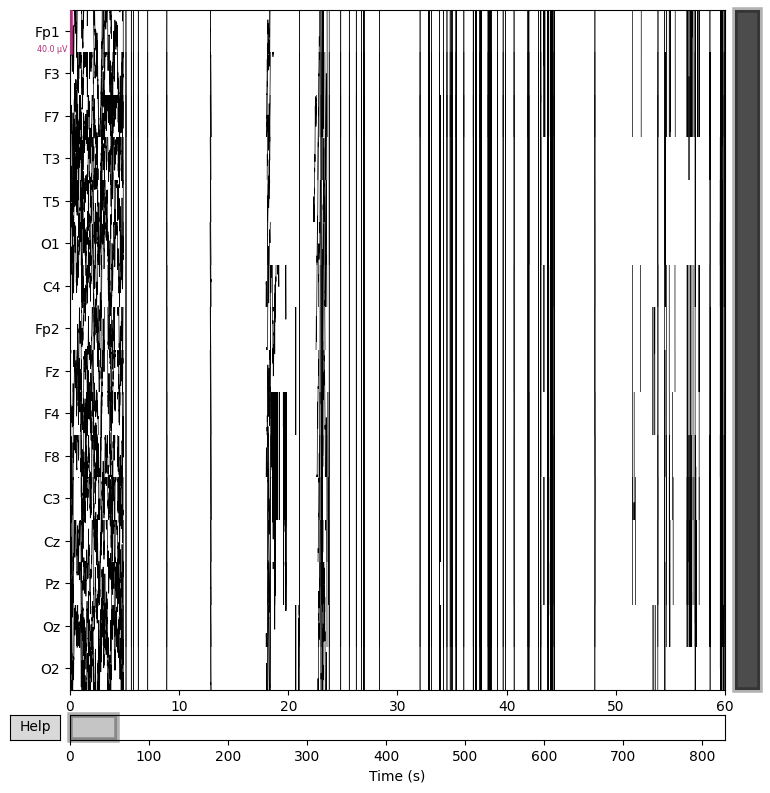

In [5]:
raw.plot(duration=60, remove_dc=False)
plt.show()

## Preprocessing

### Low-pass and high-pass filter

In [6]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
filt_raw

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



Measurement date,"November 24, 2011 10:50:28 GMT"
Experimenter,Unknown
Participant,00000000
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.02 Hz
Highpass,1.00 Hz
Lowpass,128.01 Hz


### Extract epochs

In [8]:
epochs = mne.make_fixed_length_epochs(filt_raw, duration=3, preload=True, verbose=False)
epochs

Number of events,276
Events,1: 276
Time range,0.000 – 2.996 s
Baseline,off


### Perform autoreject

In [10]:
raw.ch_names

['Fp1',
 'F3',
 'F7',
 'T3',
 'T5',
 'O1',
 'C4',
 'Fp2',
 'Fz',
 'F4',
 'F8',
 'C3',
 'Cz',
 'Pz',
 'Oz',
 'O2']

In [11]:
ar = AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, n_jobs=2, verbose=True)
ar.fit(epochs)
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

/home/fahmi/research/eegautism/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 16/16 [00:00<00:00,   24.83it/s]
100%|██████████| Computing thresholds ... : 16/16 [00:15<00:00,    1.02it/s]


































































































































100%|██████████| Repairing epochs : 276/276 [00:02<00:00,  108.87it/s]





















































































































































































































































100%|██████████| Repairing epochs : 276/276 [00:07<00:00,   35.79it/s]






















100%|██████████| Fold : 10/10 [00:02<00:00,    4.02it/s]








































































































































































































































100%|██████████| 





Estimated consensus=0.50 and n_interpolate=3





















































































































































































































100%|██████████| Repairing epochs : 276/276 [00:04<00:00,   58.15it/s]

Dropped 113 epochs: 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49, 50, 51, 52, 53, 54, 55, 61, 62, 133, 134, 135, 146, 156, 157, 158, 170, 171, 172, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 203, 217, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 234, 236, 237, 239, 240, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275


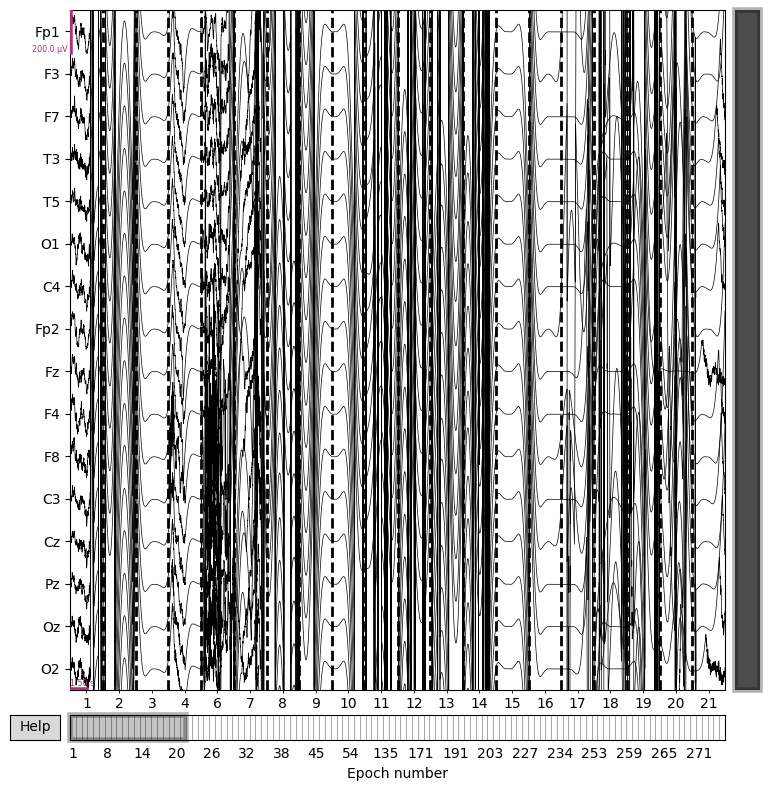

[]

In [14]:
epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6))
plt.plot()

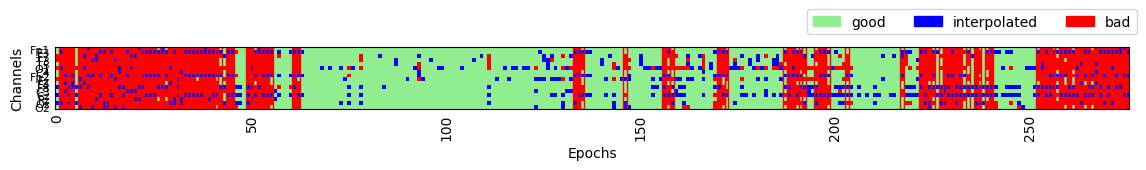

In [16]:
reject_log.plot('horizontal')
plt.show()

In [48]:
epochs_ar

Number of events,163
Events,1: 163
Time range,0.000 – 2.996 s
Baseline,off


### Perform ICA

In [53]:
ica = mne.preprocessing.ICA(max_iter="auto", random_state=97)
ica.fit(epochs_ar)
ica

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 2.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,47 iterations on epochs (125184 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


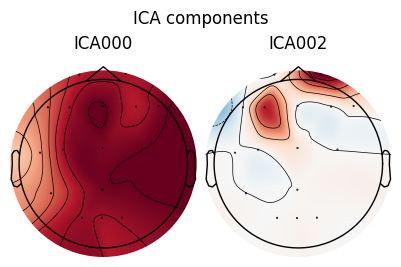

In [19]:
exclude = [0,  # blinks
           2  # saccades
           ]
ica.plot_components(exclude)
ica.exclude = exclude

Applying ICA to Evoked instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


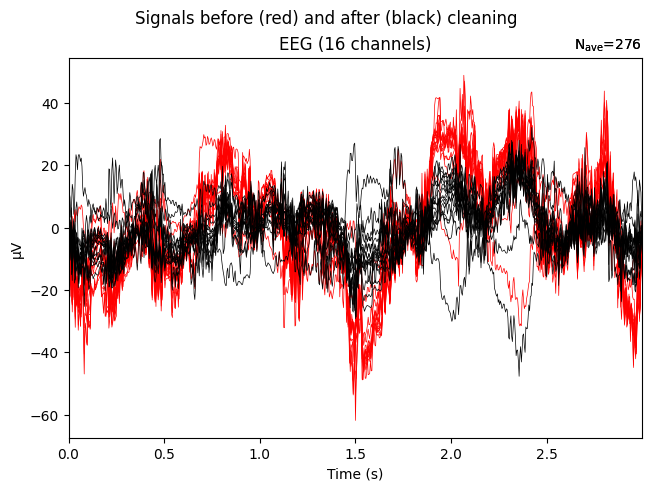

Applying ICA to Epochs instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


In [20]:
ica.plot_overlay(epochs.average(), exclude=ica.exclude)
ica.apply(epochs, exclude=ica.exclude)
plt.show()

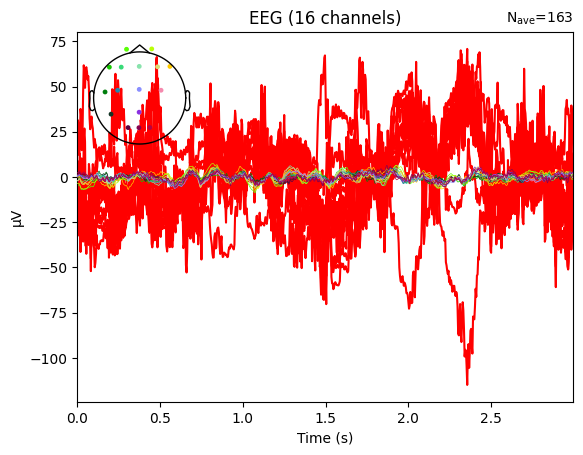

In [22]:
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca())
plt.show()

In [23]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 1.0


In [57]:
ica.get_explained_variance_ratio(filt_raw)

{'eeg': 1.0}

In [54]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw, components=[0], ch_type="eeg")

# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: -11%


In [32]:
segments = epochs[~reject_log.bad_epochs].get_data(verbose=False, copy=True)
segments.shape

(163, 16, 768)

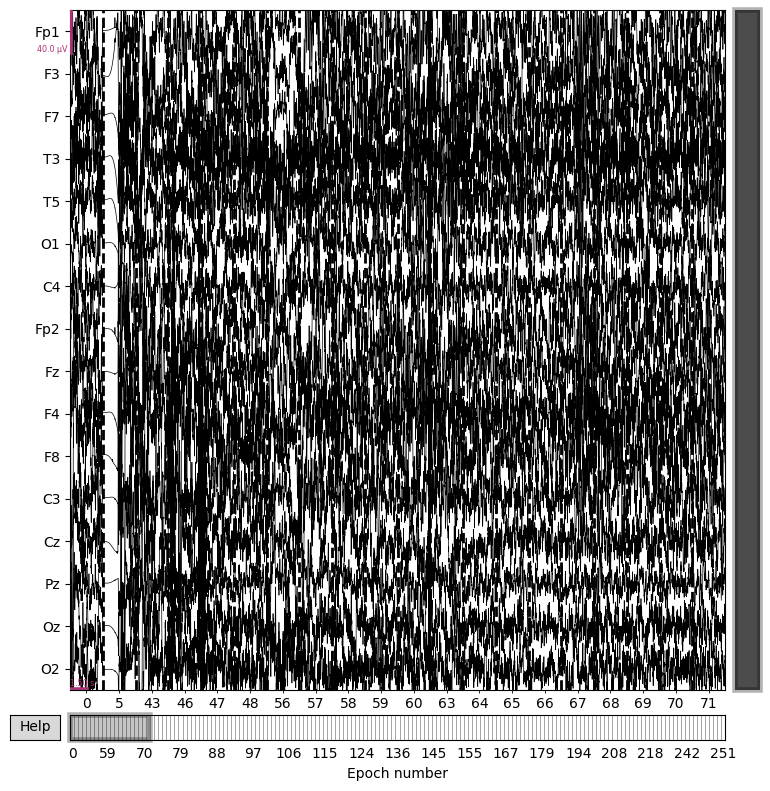

In [31]:
epochs[~reject_log.bad_epochs].plot()
plt.show()

In [36]:
reject_log.bad_epochs.astype(int)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

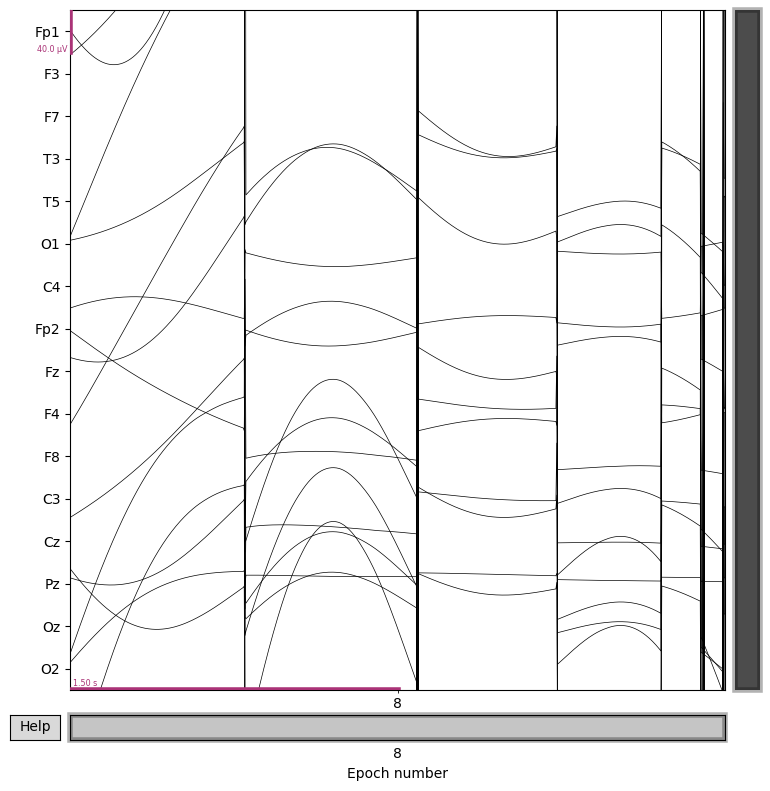

In [44]:
epochs[8].plot()
plt.show()